# Phase retrieval with gradient descent
## Recovering a pupil to generate the quantum monodromy psf with a **4-phase constraint**

In this demonstration there is known phase solution.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

import tensorflow as tf
import pickle

from funcs import *

In [2]:
# We used TensorFlow version 2.3.0
print(tf.__version__)

2.3.0


## Define physical constants

In [3]:
apix = 128 # number of pixels in the apeture
dpix = 256 # nuber of pixels on the detector

pix_size = 1e-6 # Sampling size in the focal plane (meters)
aperture = .02  # apeture size (diameter) (meters)
flen = .15      # focal length (meters)
wlen = 600e-9   # wavelength (meters)

# Scaling factor used to pad the apperture giving the desired focal plane sampling
factor = (wlen * flen) / (aperture * pix_size)

## Load target PSF

In [4]:
true_psf = np.load('./quantum_monodromy.npy')
true_psf = tf.constant(true_psf, dtype = tf.float32)

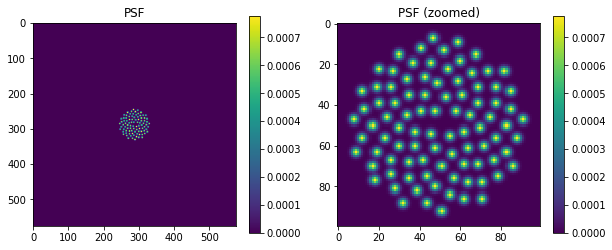

In [5]:
zoomed_psf = img_zoom(true_psf)

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1); plt.imshow(normalise(true_psf), interpolation = 'none'); plt.title('PSF'); plt.colorbar()
plt.subplot(1, 2, 2); plt.imshow(normalise(zoomed_psf), interpolation = 'none'); plt.title('PSF (zoomed)'); plt.colorbar()
plt.show()

## Initialize gradient descent

We define a circular aperture for our pupil support.

In [6]:
mag = np.zeros((apix, apix))
r = apix //2

xs = np.linspace(-r, r, apix, endpoint=True)
X, Y = np.meshgrid(xs, xs)
Rs = np.hypot(Y, X)

mag[Rs<=r] = 1
mag = tf.constant(mag, dtype = tf.float32)

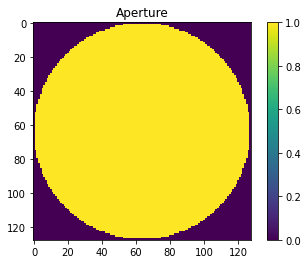

In [7]:
plt.imshow(mag, interpolation = 'none')
plt.title('Aperture')
plt.colorbar()
plt.show()

The phases are initialized randomly between -0.5 and 0.5 radians.

Here we initialize with `seed = 0`. Since gradient descent is a local optimizer, changing the seed will results in different solutions.

In [8]:
phases = tf.random.uniform((apix, apix), minval = -0.5, maxval = 0.5, seed = 0)
pupil = build_pupil(phases, mag)
pad_pupil = pad(pupil, factor = factor)
psf = intensity(FFT(pad_pupil))

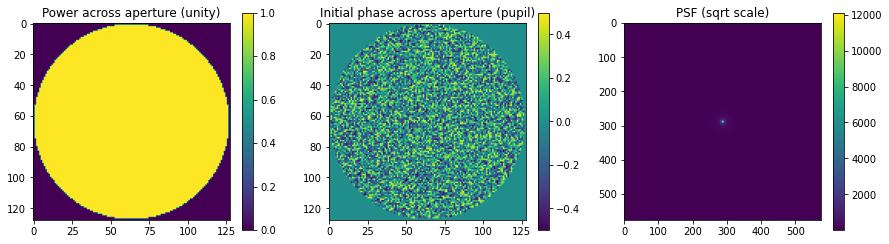

In [9]:
plt.figure(figsize = (15, 4))

plt.subplot(1, 3, 1); plt.imshow(np.abs(pupil)); plt.colorbar()
plt.title('Power across aperture (unity)')

plt.subplot(1, 3, 2); plt.imshow(np.angle(pupil)); plt.colorbar()
plt.title('Initial phase across aperture (pupil)')

plt.subplot(1, 3, 3); plt.imshow(psf**0.5); plt.colorbar()
plt.title('PSF (sqrt scale)')

plt.show()

Since we know the pupil support, we only need to recover the phase, in our gradient descent we only need to calculate gradients with respect to the phase.

In [10]:
pad_pupil = pad(pupil, factor = factor)
psf = intensity(FFT(pad_pupil))

mag = tf.abs(pad_pupil)
pha = tf.Variable(tf.math.angle(pad_pupil))

In [11]:
results = {'psfs': [], 'pupils': [], 'errors': []}

## Run gradient descent

In [12]:
def gradient_descent(phase, magnitude, epochs, learning_rate, results, c = 1e-14, save_rate = 100):

    adam = tf.optimizers.Adam(learning_rate)
    
    for i in range(epochs):

        with tf.GradientTape() as g:
            g.watch(phase)

            pad_pupil = build_pupil(phase, magnitude) 

            fft = FFT(pad_pupil)
            psf = intensity(fft)
            
            # Enforce 4 phases
            constraint = tf.reduce_sum(tf.math.abs(phase % (np.pi/2) - np.pi/4))
            
            mse_error = tf.reduce_mean(tf.math.square(tf.subtract(normalise(true_psf), normalise(psf))))
            error = mse_error + c*constraint
            
            results["errors"].append(error.numpy())

            if i % save_rate == 0:
                results["psfs"].append(psf)
                results["pupils"].append(pad_pupil[:apix, :apix])

            grads = g.gradient(error, phase)
        
        adam.apply_gradients(zip([grads], [phase]))
        
    results["psfs"].append(psf)
    results["pupils"].append(pad_pupil[:apix, :apix])
        
    return results

In [13]:
lr = 1e5
results = gradient_descent(pha, mag, 1000, lr, results, c = 1e-14)
results = gradient_descent(pha, mag, 1000, lr, results, c = 2e-14)
results = gradient_descent(pha, mag, 1000, lr, results, c = 5e-14)
results = gradient_descent(pha, mag, 1000, lr, results, c = 7.5e-14)

lr = 1e3
results = gradient_descent(pha, mag, 500, lr, results, c = 1e-13)

lr = 1e2
results = gradient_descent(pha, mag, 500, lr, results, c = 1e-13)

In [14]:
with open('./constraint.pkl', 'wb') as f:
    pickle.dump(results, f)

## Results

In [15]:
with open('./constraint.pkl', 'rb') as f:
    results = pickle.load(f)

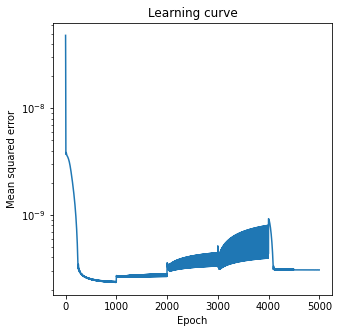

In [16]:
plt.figure(figsize = (5, 5))
plt.plot(results['errors']); plt.yscale('log')
plt.title('Learning curve'); plt.xlabel('Epoch'); plt.ylabel('Mean squared error')
plt.show()

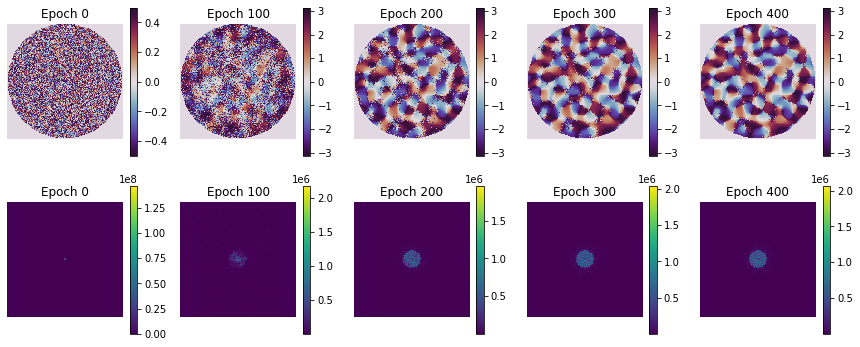

In [17]:
ncols = 5
save_rate = 100

plt.figure(figsize = (15, 6))
for i in range(ncols):
    plt.subplot(2, ncols, i + 1); plt.imshow(np.angle(results["pupils"][i]), cmap = 'twilight_shifted', interpolation = 'none'); plt.colorbar(); plt.axis('off')
    plt.title("Epoch {}".format(i * save_rate))
    
    plt.subplot(2, ncols, ncols + i + 1); plt.imshow(results["psfs"][i]); plt.colorbar(); plt.axis('off')
    plt.title("Epoch {}".format(i * save_rate))
plt.show()

## Recovered pupil and PSF

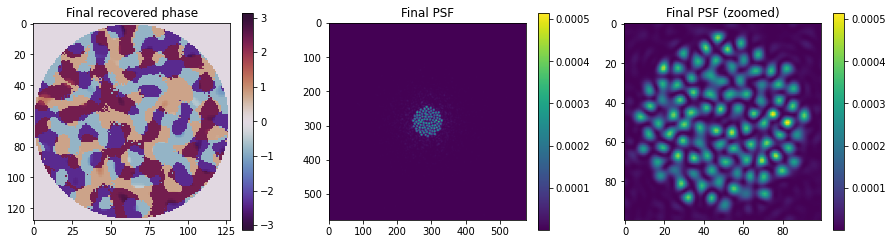

In [18]:
final_pupil = np.angle(results["pupils"][-1])
final_psf = normalise(results["psfs"][-1])

c = true_psf.shape[0]//2; 
s = 50
zoomed_psf = final_psf[c-s:c+s, c-s:c+s]

plt.figure(figsize = (15, 4))
plt.subplot(1, 3, 1); plt.imshow(final_pupil, cmap = 'twilight_shifted', interpolation = "none", vmin = -np.pi, vmax = np.pi);
plt.colorbar(); plt.title('Final recovered phase')
plt.subplot(1, 3, 2); plt.imshow(final_psf); plt.colorbar(); plt.title('Final PSF')
plt.subplot(1, 3, 3); plt.imshow(zoomed_psf); plt.colorbar(); plt.title('Final PSF (zoomed)')
plt.show()

## 'True' PSF
The 'True' PSF is entirely fabricated, and it is unknown whether a true solution exists.

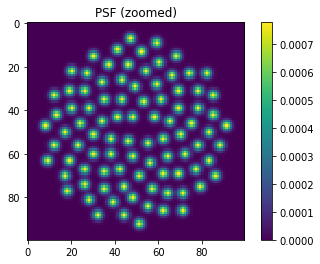

In [19]:
c = true_psf.shape[0]//2; s = 50
zoomed_psf = true_psf[c-s:c+s, c-s:c+s]

plt.imshow(normalise(zoomed_psf), interpolation = 'none'); plt.title('PSF (zoomed)'); plt.colorbar()
plt.show()